In [1]:
import cpuinfo
import numpy as np
import tensorflow as tf
import imageio
from tqdm import tqdm
import multiprocessing as mp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
cpuinfo.get_cpu_info()['brand'], tf.test.is_gpu_available()

('Intel(R) Core(TM) i5-7500 CPU @ 3.40GHz', False)

In [3]:
from utils.unet import get_compiled_model
from utils.generate_train_set import get_next_batch

Using TensorFlow backend.


In [4]:
h_size = 256
w_size = 256
start_neurons = 8
mask_pool_size = 10
train_num = 100
bg_admix_iters = 2
cores_count = mp.cpu_count()

In [5]:
train_x = None  # np.zeros((train_num, h_size, w_size, 3), dtype='float32')
train_y = None  # np.zeros((train_num, h_size, w_size, 1), dtype='float32')

# Construct model

In [6]:
model = get_compiled_model(h_size, w_size, start_neurons)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


# Load images from Google-Images

# Generate train set
- get_gi_bg (60%)
- generate_rand_bg (30%)
- get_flat_simple_bg (5%)
- get_simple_bg (5%)

In [7]:
%%time
generate_batch_size = train_num // cores_count
with mp.Pool(processes=cores_count) as pool:
    results = [
        pool.apply_async(get_next_batch, args=(generate_batch_size,))
        for _ in range(cores_count)
    ]
    for x, y in [res.get() for res in results]:
        if train_x is None:
            train_x, train_y = x, y
        else:
            train_x = np.concatenate((train_x, x), axis=0)
            train_y = np.concatenate((train_y, y), axis=0)

CPU times: user 55 ms, sys: 181 ms, total: 236 ms
Wall time: 6.09 s


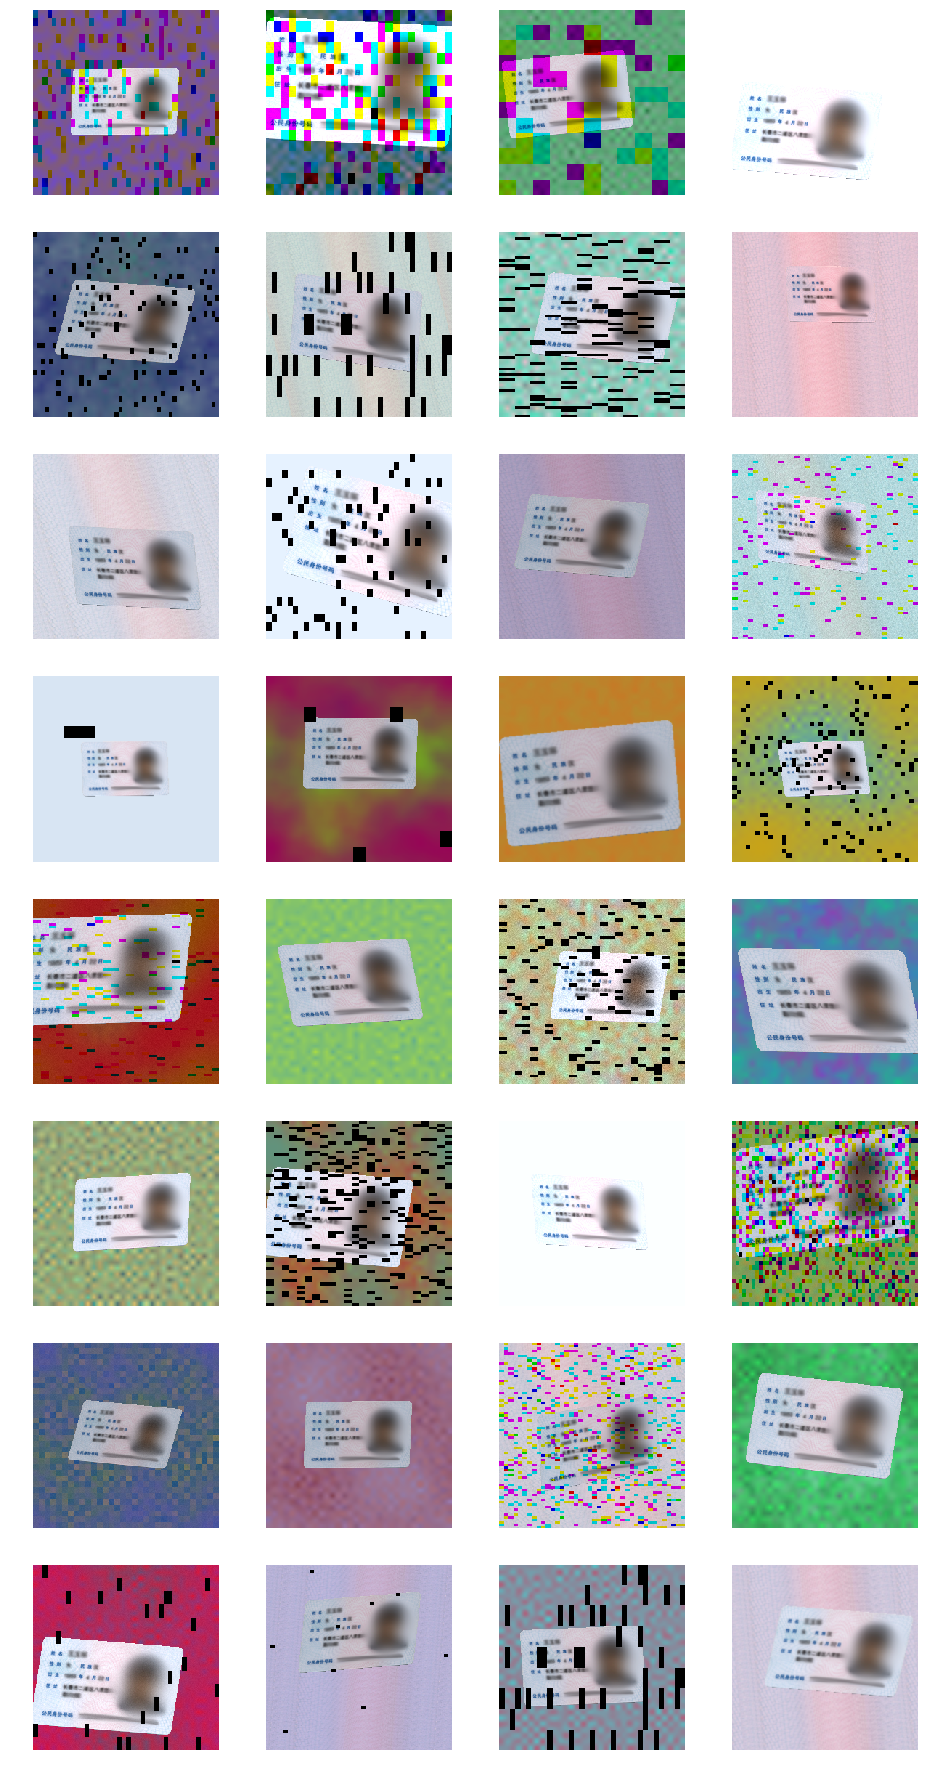

In [8]:
rows = 8
cols = 4
fig, axes = plt.subplots(rows, cols, figsize=(4*cols,4*rows))
for i in range(rows):
    for j in range(cols):
        axes[i, j].set_axis_off()
        axes[i, j].imshow(train_x[i * cols + j]);

In [9]:
# acc = []
# val_acc = []
# for _ in range (50):
#     history = model.fit(train_x, train_y,
#                         batch_size=32,
#                         epochs=1,
#                         verbose=1,
#                         validation_split=0.1
#                        )    
#     acc_ = history.history['my_iou_metric'][0]
#     val_acc_ = history.history['val_my_iou_metric'][0]
#     acc.append(acc_)
#     val_acc.append(val_acc_)
#     if acc_ > 0.99:
#         break

In [10]:
# df = pd.DataFrame({'x': list(range(len(acc))), 'y': acc})
# sns.lmplot(x="x", y="y", data=df, order=2);

In [11]:
# df = pd.DataFrame({'x': list(range(len(val_acc))), 'y': val_acc})
# sns.lmplot(x="x", y="y", data=df, order=2);